#**Project 1 Announcement**
Objective: Generate faces with GAN



Model: DCGAN (which is provided in Practice 6)

  - You can use other models of your choice.



Dataset: CelebA

  - Resolution: 64x64

  - Use a preprocessing step to convert 218x178 to 64x64

  - transforms.Compose([transforms.Resize(64), transforms.CenterCrop(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  - You can download CelebA in the same manner you downloaded MNIST using torchvision.

  - CelebA dataset is hosted on Google Drive, which restricts the number of downloads per day (or per several hours). If you fail to download, try it again in a few hours. Or you can download the dataset locally.



Evaluation: FID Score

  - Based on 1,000 generated samples.

  - Below FID 30 -> +5

  - Below FID 35 -> 45 (out of 45)

  - Below FID 45 -> -5

  - Below FID 55 -> -10



Submission(IMPORTANT)

  - Compress 1,000 synthetic images in PNG format into "student_number.tar.gz" (eg. 20204386.tar.gz)

  - Do NOT include folders, codes or readme.txt. JUST ONLY 1,000 PNG IMAGES.

    (When TAs decompress the submitted tar.gz, only 1,000 PNG files should exist. No folders, no README, no codes. JUST IMAGES.)

  - Upload the compressed file on KLMS. (Naver engineers should send it directly to my email swc1905@kaist.ac.kr)

  - You’ll get a PENALTY if you don’t follow the submission format above.



Things to consider

  - The pixel values of the real and fake images are in the range of [-1, 1]. Before you save the images using vutils.save_image(), you have to make the pixel values in the range of [0, 1]. Otherwise, you will save reddish strange images.

  - image_tensor = (image_tensor * 0.5) + 0.5 : [-1, 1] -> [0, 1]



Due Date

  - Oct. 28th 23:59pm.

  - NO LATE SUBMISSION.



If you have any questions, please reply to this post.



Regards,

Woncheol Shin

In [1]:
### Google drive mount ###
from google.colab import drive 
drive.mount('/content/gdrive/')
### ------------------------------------------ ###

Mounted at /content/gdrive/


In [2]:
# visualize current GPU usages in your server
!nvidia-smi 

Thu Oct 28 07:53:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# set gpu by number 
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [4]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid


In [5]:
from tqdm import tqdm

In [6]:
# Create folders
dir = '/content/gdrive/MyDrive/Colab/DCGAN'
# os.path.join(, f"{args.resnet_version}", f"{args.optim}", f"{datetime.now().strftime('%m%d%H')}")
# f'{dir}/image_{i}.png'
if not os.path.exists(f'{dir}/checkpoint'):
    os.mkdir(f'{dir}/checkpoint')
    
if not os.path.exists(f'{dir}/dataset'):
    os.mkdir(f'{dir}/dataset')
    
if not os.path.exists(f'{dir}/img'):
    os.mkdir(f'{dir}/img')
    
if not os.path.exists(f'{dir}/img/real'):
    os.mkdir(f'{dir}/img/real')

if not os.path.exists(f'{dir}/img/fake'):
    os.mkdir(f'{dir}/img/fake')

In [7]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [8]:
def save_gif(training_progress_images, images, epoch):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave(f'{dir}/img/training_progress_{epoch}.gif', training_progress_images)
    return training_progress_images

In [9]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [10]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [11]:
def save_image_list(dataset, real):
    if real:
        base_path = f'{dir}/img/real'
    else:
        base_path = f'{dir}/img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

In [12]:
dataroot = "/content/gdrive/MyDrive/Colab/dataset/CelebA"
beta1 = 0.5
image_size = 64
lr = 0.0002
nc = 3
nz = 100 # input noise dimension
ndf = 64
ngf = 64
batch_size = 128
pretrained = True
ckpt = '/content/gdrive/MyDrive/Colab/DCGAN/checkpoint'
model_num = 138
num_epochs = 200

018062.jpg


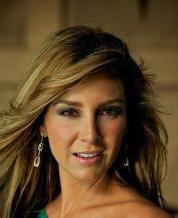

In [19]:
from IPython.display import Image
number = str(random.randint(1, 202599)).zfill(6)
print(f'{number}.jpg')
Image(f'{dataroot}/img_align_celeba/{number}.jpg')

In [20]:
celebaset = dset.ImageFolder(root=dataroot, 
                             transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]))

dataloader = torch.utils.data.DataLoader(celebaset, batch_size=batch_size, shuffle=True, num_workers=100)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [23]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [24]:
netDCG = DCGenerator()
netDCD = DCDiscriminator()

In [25]:
if pretrained:
  netDCG.load_state_dict(torch.load(f'{ckpt}/netDCG_epoch_%d.pth' % (model_num-1)))
  netDCD.load_state_dict(torch.load(f'{ckpt}/netDCD_epoch_%d.pth' % (model_num-1)))

In [26]:
netDCG = netDCG.to(device)
netDCD = netDCD.to(device)

optimizerDCD = optim.Adam(netDCD.parameters(), lr=lr)
optimizerDCG = optim.Adam(netDCG.parameters(), lr=lr)

In [27]:
#### Implement here ####
noise = torch.randn(batch_size, nz, 1, 1, device=device)

In [ ]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

criterion = nn.BCELoss()

n_epoch = num_epochs - (model_num)
training_progress_images_list = []

for epoch in tqdm(range(n_epoch), desc=f'Training'):
    for i, (data, _) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+(model_num)+1}/{num_epochs}')):
        ####################################################
        # (1) Update DCD network: maximize log(D(x)) + log(1 - DCD(G(z))) #
        ###################################################
        # train with real
        netDCD.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)
        label = torch.ones((batch_size,)).to(device) # real label = 1
        output = netDCD(data)
        errDCD_real = criterion(output, label)
        # errDCD_real.backward()
        DCD_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netDCG(noise)
        label = torch.zeros((batch_size,)).to(device) # fake label = 1
        output = netDCD(fake.detach())
        errDCD_fake = criterion(output, label)
        # errDCD_fake.backward()
        DCD_G_z1 = output.mean().item()
        
        # Loss backward
        errDCD = errDCD_real + errDCD_fake
        errDCD.backward()
        optimizerDCD.step()

        ########################################
        # (2) Update DCG network: maximize log(DCD(G(z))) #
        ########################################
        netDCG.zero_grad()
        label = torch.ones((batch_size,)).to(device)  # fake labels are real for generator cost
        output = netDCD(fake)
        errDCG = criterion(output, label)
        DCD_G_z2 = output.mean().item()

        errDCG.backward()
        optimizerDCG.step()
        
    print('[%d/%d] Loss_DCD: %.4f Loss_DCG: %.4f DCD(x): %.4f DCD(G(z)): %.4f / %.4f' 
              % (epoch+(model_num+1), num_epochs, errDCD.item(), errDCG.item(), DCD_x, DCD_G_z1, DCD_G_z2))
    
    #save the output
    fake = netDCG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake, epoch+model_num+1)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netDCG.state_dict(), f'{dir}/checkpoint/netDCG_epoch_%d.pth' % (epoch+(model_num)))
    torch.save(netDCD.state_dict(), f'{dir}/checkpoint/netDCD_epoch_%d.pth' % (epoch+(model_num)))
    print('Save the model at epoch %d' % (epoch+(model_num)+1))

Epoch 123/200:   0%|          | 0/1583 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Epoch 123/200: 100%|██████████| 1583/1583 [30:51<00:00,  1.17s/it]


[123/200] Loss_DCD: 0.0050 Loss_DCG: 7.4840 DCD(x): 0.9989 DCD(G(z)): 0.0039 / 0.0039


Training:   1%|▏         | 1/78 [30:52<39:37:19, 1852.46s/it]

Save the model at epoch 123



Epoch 124/200: 100%|██████████| 1583/1583 [14:20<00:00,  1.84it/s]


[124/200] Loss_DCD: 0.0117 Loss_DCG: 7.8844 DCD(x): 0.9919 DCD(G(z)): 0.0030 / 0.0034


Training:   3%|▎         | 2/78 [45:14<26:48:08, 1269.58s/it]

Save the model at epoch 124



Epoch 125/200: 100%|██████████| 1583/1583 [14:20<00:00,  1.84it/s]


[125/200] Loss_DCD: 0.0302 Loss_DCG: 7.7696 DCD(x): 0.9998 DCD(G(z)): 0.0198 / 0.0072


Training:   4%|▍         | 3/78 [59:35<22:34:13, 1083.38s/it]

Save the model at epoch 125



Epoch 126/200: 100%|██████████| 1583/1583 [14:22<00:00,  1.84it/s]


[126/200] Loss_DCD: 0.1137 Loss_DCG: 8.2226 DCD(x): 0.9286 DCD(G(z)): 0.0086 / 0.0066


Training:   5%|▌         | 4/78 [1:13:59<20:29:25, 996.84s/it]

Save the model at epoch 126



Epoch 127/200: 100%|██████████| 1583/1583 [14:19<00:00,  1.84it/s]


[127/200] Loss_DCD: 0.0087 Loss_DCG: 8.1571 DCD(x): 0.9991 DCD(G(z)): 0.0069 / 0.0038


Training:   6%|▋         | 5/78 [1:28:21<19:13:30, 948.08s/it]

Save the model at epoch 127



Epoch 128/200: 100%|██████████| 1583/1583 [14:21<00:00,  1.84it/s]


[128/200] Loss_DCD: 0.0552 Loss_DCG: 6.8002 DCD(x): 0.9582 DCD(G(z)): 0.0067 / 0.0127


Training:   8%|▊         | 6/78 [1:42:46<18:23:37, 919.68s/it]

Save the model at epoch 128



Epoch 129/200: 100%|██████████| 1583/1583 [14:23<00:00,  1.83it/s]


[129/200] Loss_DCD: 0.0485 Loss_DCG: 8.7175 DCD(x): 0.9804 DCD(G(z)): 0.0214 / 0.0034


Training:   9%|▉         | 7/78 [1:57:12<17:47:32, 902.15s/it]

Save the model at epoch 129



Epoch 130/200: 100%|██████████| 1583/1583 [14:21<00:00,  1.84it/s]


[130/200] Loss_DCD: 0.0153 Loss_DCG: 9.2900 DCD(x): 0.9988 DCD(G(z)): 0.0115 / 0.0027


Training:  10%|█         | 8/78 [2:11:37<17:18:49, 890.42s/it]

Save the model at epoch 130



Epoch 131/200: 100%|██████████| 1583/1583 [14:23<00:00,  1.83it/s]


[131/200] Loss_DCD: 0.0092 Loss_DCG: 10.5023 DCD(x): 0.9985 DCD(G(z)): 0.0064 / 0.0009


Training:  12%|█▏        | 9/78 [2:26:05<16:55:53, 883.38s/it]

Save the model at epoch 131



Epoch 132/200: 100%|██████████| 1583/1583 [14:26<00:00,  1.83it/s]


[132/200] Loss_DCD: 0.0202 Loss_DCG: 9.5461 DCD(x): 0.9837 DCD(G(z)): 0.0012 / 0.0012


Training:  13%|█▎        | 10/78 [2:40:36<16:36:43, 879.47s/it]

Save the model at epoch 132



Epoch 133/200: 100%|██████████| 1583/1583 [14:26<00:00,  1.83it/s]


[133/200] Loss_DCD: 0.0191 Loss_DCG: 7.7055 DCD(x): 0.9902 DCD(G(z)): 0.0082 / 0.0040


Training:  14%|█▍        | 11/78 [2:55:07<16:19:26, 877.11s/it]

Save the model at epoch 133



Epoch 134/200: 100%|██████████| 1583/1583 [14:26<00:00,  1.83it/s]


[134/200] Loss_DCD: 0.0269 Loss_DCG: 9.1351 DCD(x): 0.9990 DCD(G(z)): 0.0191 / 0.0038


Training:  15%|█▌        | 12/78 [3:09:39<16:03:05, 875.55s/it]

Save the model at epoch 134



Epoch 135/200: 100%|██████████| 1583/1583 [14:27<00:00,  1.82it/s]


[135/200] Loss_DCD: 0.0088 Loss_DCG: 11.5654 DCD(x): 0.9925 DCD(G(z)): 0.0007 / 0.0004


Training:  17%|█▋        | 13/78 [3:24:12<15:47:41, 874.79s/it]

Save the model at epoch 135



Epoch 136/200: 100%|██████████| 1583/1583 [14:28<00:00,  1.82it/s]


[136/200] Loss_DCD: 0.0374 Loss_DCG: 7.3920 DCD(x): 0.9734 DCD(G(z)): 0.0035 / 0.0063


Training:  18%|█▊        | 14/78 [3:38:47<15:33:05, 874.77s/it]

Save the model at epoch 136



Epoch 137/200: 100%|██████████| 1583/1583 [14:28<00:00,  1.82it/s]


[137/200] Loss_DCD: 0.0267 Loss_DCG: 8.7181 DCD(x): 0.9773 DCD(G(z)): 0.0006 / 0.0011


Training:  19%|█▉        | 15/78 [3:53:22<15:18:39, 874.91s/it]

Save the model at epoch 137



Epoch 138/200: 100%|██████████| 1583/1583 [14:30<00:00,  1.82it/s]


[138/200] Loss_DCD: 0.0036 Loss_DCG: 8.8605 DCD(x): 0.9996 DCD(G(z)): 0.0032 / 0.0027


Training:  21%|██        | 16/78 [4:07:59<15:04:38, 875.46s/it]

Save the model at epoch 138



Epoch 139/200: 100%|██████████| 1583/1583 [14:34<00:00,  1.81it/s]


[139/200] Loss_DCD: 0.0047 Loss_DCG: 7.8101 DCD(x): 0.9995 DCD(G(z)): 0.0042 / 0.0057


Training:  22%|██▏       | 17/78 [4:22:40<14:51:48, 877.19s/it]

Save the model at epoch 139



Epoch 140/200: 100%|██████████| 1583/1583 [14:35<00:00,  1.81it/s]


[140/200] Loss_DCD: 0.1033 Loss_DCG: 9.5880 DCD(x): 0.9322 DCD(G(z)): 0.0024 / 0.0035


Training:  23%|██▎       | 18/78 [4:37:24<14:39:06, 879.10s/it]

Save the model at epoch 140



Epoch 141/200: 100%|██████████| 1583/1583 [14:38<00:00,  1.80it/s]


[141/200] Loss_DCD: 0.0189 Loss_DCG: 7.7617 DCD(x): 0.9867 DCD(G(z)): 0.0051 / 0.0041


Training:  24%|██▍       | 19/78 [4:52:11<14:26:41, 881.38s/it]

Save the model at epoch 141



Epoch 142/200: 100%|██████████| 1583/1583 [14:39<00:00,  1.80it/s]


[142/200] Loss_DCD: 0.0455 Loss_DCG: 8.2778 DCD(x): 0.9651 DCD(G(z)): 0.0028 / 0.0029


Training:  26%|██▌       | 20/78 [5:06:59<14:14:01, 883.47s/it]

Save the model at epoch 142



Epoch 143/200: 100%|██████████| 1583/1583 [14:41<00:00,  1.80it/s]


[143/200] Loss_DCD: 0.0182 Loss_DCG: 7.0741 DCD(x): 0.9981 DCD(G(z)): 0.0149 / 0.0092


Training:  27%|██▋       | 21/78 [5:21:50<14:01:23, 885.68s/it]

Save the model at epoch 143



Epoch 144/200: 100%|██████████| 1583/1583 [14:42<00:00,  1.79it/s]


[144/200] Loss_DCD: 0.2100 Loss_DCG: 5.7338 DCD(x): 0.9950 DCD(G(z)): 0.1248 / 0.0639


Training:  28%|██▊       | 22/78 [5:36:42<13:48:20, 887.50s/it]

Save the model at epoch 144



Epoch 145/200: 100%|██████████| 1583/1583 [14:46<00:00,  1.79it/s]


[145/200] Loss_DCD: 0.0021 Loss_DCG: 9.5734 DCD(x): 0.9994 DCD(G(z)): 0.0015 / 0.0016


Training:  29%|██▉       | 23/78 [5:51:38<13:35:57, 890.14s/it]

Save the model at epoch 145



Epoch 146/200:  91%|█████████▏| 1445/1583 [13:29<01:11,  1.92it/s]


In [ ]:
# vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

NameError: ignored

In [ ]:
import inception
import fid_score
from fid_score import calculate_fid_given_paths

In [ ]:
# test_dataset = dset.ImageFolder(root=dataroot,
#                              transform=transforms.Compose([
#                                   transforms.Resize(image_size),
#                                   transforms.CenterCrop(image_size),
#                                   transforms.ToTensor(),
#                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                               ]))

# dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True, num_workers=2)

# for i, (data, _) in enumerate(dataloader):
#     real_dataset = data
#     break

noise = torch.randn(1000, nz, 1, 1, device=device)
fake_dataset = netDCG(noise)

In [ ]:
# real_image_path_list = save_image_list(real_dataset, True)
# fake_image_path_list = save_image_list(fake_dataset, False)
# real_image_path_list = save_image_list((real_dataset * 0.5) + 0.5, True)
fake_image_path_list = save_image_list((fake_dataset * 0.5) + 0.5, False)
real_image_path_list = f'{dir}/img/real'

In [ ]:
# calculate_fid_given_paths(paths, batch_size, cuda, dims)
fid_value = calculate_fid_given_paths([real_image_path_list, fake_image_path_list],
                                                          50, 
                                                          True,
                                                          2048)

100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


In [ ]:
print (f'FID score: {fid_value}')

FID score: 37.60628042660957
